In [1]:
import sys
sys.path.append('/Users/mader/Dropbox/Informatics/pyqae-master')
from pyqae import PyqaeContext

In [2]:
from dicom import read_file as dicom_simple_read
import numpy as np
from glob import glob
import pandas as pd

In [3]:
def local_read_depth(in_folder, depth, ext = '.dcm', inc_parent = False):
    """
    Read recursively from a list of directories
    :param in_folder: the base path to start from
    :param depth: the depth to look in the tree
    :param ext: the extension to search for
    :param inc_parent: to include the results from parent directories as well
    :return: a list of files
    """
    c_path = [in_folder]
    out_files = []
    for i in range(depth+1):
        c_wc_path = os.path.join(*(c_path + ['*']*i + ['*'+ext]))
        out_files += [] if (not inc_parent) and (i<depth) else glob(c_wc_path)
    return out_files

In [4]:
c_files = local_read_depth('/Users/mader/Dropbox/4Quant/Projects/TumorSegmentation/10092825', 1, inc_parent = False)

In [5]:
temp_dicom = dicom_simple_read(c_files[0])

In [6]:
for i, row in enumerate(temp_dicom):
    print(i, row)

0 (0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'NORM', 'DIS2D']
1 (0008, 0012) Instance Creation Date              DA: '20140606'
2 (0008, 0013) Instance Creation Time              TM: '111951.093000'
3 (0008, 0016) SOP Class UID                       UI: MR Image Storage
4 (0008, 0018) SOP Instance UID                    UI: 1.3.12.2.1107.5.2.32.35424.2014060611195066449861833
5 (0008, 0020) Study Date                          DA: '20140606'
6 (0008, 0021) Series Date                         DA: '20140606'
7 (0008, 0022) Acquisition Date                    DA: '20140606'
8 (0008, 0023) Content Date                        DA: '20140606'
9 (0008, 0030) Study Time                          TM: '111723.734000'
10 (0008, 0031) Series Time                         TM: '111951.062000'
11 (0008, 0032) Acquisition Time                    TM: '111825.792500'
12 (0008, 0033) Content Time                        TM: '111951.093000'
13 (0008, 0050) Accession Numbe

In [9]:
from collections import namedtuple
from pyspark.sql.types import _infer_type, _has_nulltype, StructType, MapType, ArrayType
from pyspark.sql import Row
import dicom
type_info = namedtuple('type_info', ['inferrable', 'realtype', 'has_nulltype', 'length', 'is_complex'])

def _tlen(x):
    """
    Try to calculate the length, otherwise return 1
    """
    try:
        return len(x)
    except:
        try:
            if np.isnan(x): return 0
        except:
            pass
        return 1

def _tnonempty(x):
    return _tlen(x)>0
def safe_type_infer(x):
    COMPLEX_TYPES = (StructType, MapType)
    try:
        sq_type = _infer_type(x)
        return type_info(True, sq_type, has_nulltype = _has_nulltype(sq_type), 
                         length = _tlen(x), is_complex = (type(sq_type) in COMPLEX_TYPES)
                        )
    except:
        return type_info(False, type(x), has_nulltype = False, 
                         length = _tlen(x), is_complex = False)

def _identify_column_types(in_df_dict):
    return dict([(k, safe_type_infer(v)) for (k, v) in in_df_dict.items()])

def _findvalidvalues(crow): 
        nz_vals = list(filter(_tnonempty, crow))
        return None if len(nz_vals)<1 else nz_vals[0]
def _countmissingvalues(crow): 
        nz_vals = list(filter(lambda i: not _tnonempty(i), crow))
        return len(nz_vals)
BAD_COLUMNS = tuple()

def dicom_to_dict(in_dicom, read_array = True):
    temp_dict = {a.name:a.value for a in in_dicom.iterall()}
    if in_dicom.__dict__.get('_pixel_array',None) is not None:
        temp_dict['Pixel Array'] = in_dicom.pixel_array.tolist()
    df_dicom = pd.DataFrame([temp_dict]) # just for the type conversion
    
    cur_kv_pairs = list(df_dicom.T.to_dict().values())[0] # first row
    valid_keys =_identify_column_types(cur_kv_pairs)
    do_keep = lambda key ,ti: ti.inferrable & (not ti.has_nulltype) & (not ti.is_complex)# & (ti.length>0)
    fvalid_keys = dict([ (k, do_keep(k,t_info)) for k, t_info in valid_keys.items()])
    return (dict([(k,v) for (k,v) in cur_kv_pairs.items() if fvalid_keys.get(k)]), 
            dict([(k,v) for (k,v) in cur_kv_pairs.items() if not fvalid_keys.get(k)]),
            valid_keys)

def dicoms_to_dict(dicom_list):
    fvr = lambda x: None if x.first_valid_index() is None else x[x.first_valid_index()]
    
    out_list = []
    
    for in_dicom in dicom_list:
        temp_dict = {a.name:a.value for a in in_dicom.iterall()}
        if in_dicom.__dict__.get('_pixel_array',None) is not None:
            temp_dict['Pixel Array'] = in_dicom.pixel_array.tolist()

        out_list += [temp_dict]
    df_dicom = pd.DataFrame(out_list) # just for the type conversion
    fvi_series = df_dicom.apply(_findvalidvalues, axis=0).to_dict()
    valid_keys = _identify_column_types(fvi_series)
    do_keep = lambda key, ti: ti.inferrable & (not ti.has_nulltype) # & (not ti.is_complex) & (ti.length>0)
    fvalid_keys = dict([ (k, do_keep(k,t_info)) for k, t_info in valid_keys.items()])
    good_columns = list(map(lambda x: x[0], filter(lambda x: x[1], fvalid_keys.items())))
    bad_columns = list(map(lambda x: x[0], filter(lambda x: not x[1], fvalid_keys.items())))
    sql_df = df_dicom[good_columns] 
    return sql_df.dropna(axis = 1)

def _remove_empty_columns(in_df):
    empty_cols = dict(filter(lambda kv: kv[1]>0, in_df.apply(_countmissingvalues,axis = 0).to_dict().items()))
    # remove missing columns
    return in_df[[ccol for ccol in in_df.columns if empty_cols.get(ccol,0)==0]]

# perform conversions
_dicom_conv_dict = {dicom.multival.MultiValue: lambda x: np.array(x).tolist(),
                   dicom.sequence.Sequence: lambda seq: [[(str(d_ele.tag), str(d_ele.value)) for d_ele in d_set] for d_set in seq]}

def _apply_conv_dict(in_ele):
    cnv_fcn = _dicom_conv_dict.get(type(in_ele[0]), None)
    if cnv_fcn is not None:
        return in_ele.map(cnv_fcn)
    else:
        return in_ele
def _conv_df(in_df):
    return in_df.apply(_apply_conv_dict)

def dicom_paths_to_df(in_path_list):
    f_df = dicoms_to_dict([dicom_simple_read(in_path, stop_before_pixels=True) for in_path in in_path_list])
    f_df['DICOMPath4Q'] = in_path_list
    rec_df = _remove_empty_columns(f_df)
    conv_df = _conv_df(rec_df)
    return conv_df

In [10]:
dicom_df = dicom_paths_to_df(c_files)
tdf = sqlContext.createDataFrame(dicom_df)
tdf.registerTempTable('DICOMSingleTable')
sqlContext.sql("""SELECT * FROM DICOMSingleTable LIMIT 1""").toPandas()

,[SliceMeasurementDuration],Accession Number,Number of Phase Encoding Steps,Study ID,Patient ID,Samples per Pixel,Manufacturer's Model Name,[SlicePosition_PCS],Protocol Name,[CoilString],...,Angio Flag,Slice Location,High Bit,Instance Creation Date,Manufacturer,Imaging Frequency,Sequence Name,Percent Phase Field of View,Private Creator,DICOMPath4Q
0,80337.5,ME140606MR3016,384,685351,10092825,1,TrioTim,"[-111.98122861, -119.99775317, 45.05843735]",t2_blade_tra,C:HEA;HEP;NE2,...,N,51.058437,7,20140606,SIEMENS,123.258578,tseBR2d1_28,100.0,SIEMENS MR HEADER,/Users/mader/Dropbox/4Quant/Projects/TumorSegm...


In [64]:
sqlContext.sql("""SELECT DICOMPath4Q, Modality FROM DICOMSingleTable LIMIT 1""").toPandas()

,DICOMPath4Q,Modality
0,/Users/mader/Dropbox/4Quant/Projects/TumorSegm...,MR


In [51]:
from pyspark.sql import functions as F
import pyspark.sql.types as sq_types
_sq_conv_map = {
    np.int16: sq_types.IntegerType,
    np.uint8: sq_types.IntegerType,
    np.float32: sq_types.FloatType,
    np.float64: sq_types.DoubleType
}

def _ndarray_to_sql(in_arr):
    """
    
    _ndarray_to_sql(np.zeros((3,3,3), np.float32))
    >>> ArrayType(ArrayType(ArrayType(FloatType,true),true),true)
    
    _ndarray_to_sql(np.zeros((3,3,3), np.int16))
    >>> ArrayType(ArrayType(ArrayType(IntegerType,true),true),true)
    
    _ndarray_to_sql(np.zeros((3,3,3), np.object))
    Exception: object is not supported in SparkSQL
    """
    assert type(in_arr) is np.ndarray, "Only works for NDArrays"
    for (dtype, stype) in _sq_conv_map.items():
        if dtype == in_arr.dtype:
            base_type = stype() # instantiate
            for c_dim in in_arr.shape:
                base_type = sq_types.ArrayType(base_type)
            return base_type
        
    raise Exception("{} is not supported in SparkSQL".format(in_arr.dtype))


twod_arr_type = sq_types.ArrayType(sq_types.ArrayType(sq_types.IntegerType()))
# the pull_input_tile function is wrapped into a udf to it can be applied to create the new image column
# numpy data is not directly supported and typed arrays must be used instead therefor we run the .tolist command
read_dicom_slice_udf = F.udf(lambda x: dicom_simple_read(x).pixel_array.tolist(), returnType = twod_arr_type)

In [52]:
t_img_df = tdf.withColumn("Pixel Array", read_dicom_slice_udf(tdf['DICOMPath4Q']))

In [155]:
from PIL import Image as PImage
from matplotlib.pyplot import cm
import base64
from io import BytesIO
def _np_to_uri(in_array, cmap = 'RdBu'):
    """
    
    _np_to_uri(np.zeros((100,100))
    >>> 'iVBORw0KGgoAAAANSUhEUgAAAIAAAACACAYAAADDPmHLAAABUElEQVR4nO3SQQEAEADAQBQRT/8ExPDYXYI9Ns/Yd5C1fgfwlwHiDBBngDgDxBkgzgBxBogzQJwB4gwQZ4A4A8QZIM4AcQaIM0CcAeIMEGeAOAPEGSDOAHEGiDNAnAHiDBBngDgDxBkgzgBxBogzQJwB4gwQZ4A4A8QZIM4AcQaIM0CcAeIMEGeAOAPEGSDOAHEGiDNAnAHiDBBngDgDxBkgzgBxBogzQJwB4gwQZ4A4A8QZIM4AcQaIM0CcAeIMEGeAOAPEGSDOAHEGiDNAnAHiDBBngDgDxBkgzgBxBogzQJwB4gwQZ4A4A8QZIM4AcQaIM0CcAeIMEGeAOAPEGSDOAHEGiDNAnAHiDBBngDgDxBkgzgBxBogzQJwB4gwQZ4A4A8QZIM4AcQaIM0CcAeIMEGeAOAPEGSDOAHEGiDNAnAHiDBBngDgDxBkgzgBxDxypAoX8C2RlAAAAAElFTkSuQmCC'
    """
    test_img_data = np.array(in_array).astype(np.float32)
    test_img_data -= test_img_data.mean()
    test_img_data /= test_img_data.std()
    test_img_color = cm.((test_img_data+0.5).clip(0,1))
    p_data = PImage.fromarray((test_img_color*255).clip(0,255).astype(np.uint8))
    rs_p_data = p_data.resize((128, 128), resample = PImage.BICUBIC)
    out_img_data = BytesIO()
    rs_p_data.save(out_img_data, format = 'png')
    out_img_data.seek(0)
    return base64.b64encode(out_img_data.read()).decode("ascii").replace("\n", "")
image_to_uri_udf = F.udf(_np_to_uri, returnType = sq_types.StringType())

In [177]:
t_prev_df = t_img_df.withColumn("Preview4Q", image_to_uri_udf(t_img_df['Pixel Array']))

In [178]:
_wrap_uri = lambda data_uri: "data:image/png;base64,{0}".format(data_uri)
def display_uri(uri_list):
    """
    
    show_uri(_np_to_uri(np.zeros((100,100))))
    
    """
    from IPython.display import HTML
    out_html = ""
    for in_uri in uri_list:
        out_html += """<img src="{0}" width = "100px" height = "100px" />""".format(_wrap_uri(in_uri))
    return HTML(out_html)


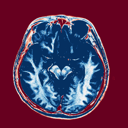

In [172]:
display_uri(t_prev_df.take(5)['Preview4Q'])

In [176]:
test_ds = t_prev_df.take(2)

Py4JJavaError: An error occurred while calling z:org.apache.spark.sql.execution.python.EvaluatePython.takeAndServe.
: org.apache.spark.SparkException: Job 33 cancelled because Stage 41 was cancelled
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1450)
	at org.apache.spark.scheduler.DAGScheduler.handleJobCancellation(DAGScheduler.scala:1389)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleStageCancellation$1.apply$mcVI$sp(DAGScheduler.scala:1377)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleStageCancellation$1.apply(DAGScheduler.scala:1376)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleStageCancellation$1.apply(DAGScheduler.scala:1376)
	at scala.collection.IndexedSeqOptimized$class.foreach(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofInt.foreach(ArrayOps.scala:234)
	at org.apache.spark.scheduler.DAGScheduler.handleStageCancellation(DAGScheduler.scala:1376)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1632)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1618)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1607)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:632)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1871)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1884)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1897)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:347)
	at org.apache.spark.sql.execution.python.EvaluatePython$$anonfun$takeAndServe$1.apply$mcI$sp(EvaluatePython.scala:41)
	at org.apache.spark.sql.execution.python.EvaluatePython$$anonfun$takeAndServe$1.apply(EvaluatePython.scala:39)
	at org.apache.spark.sql.execution.python.EvaluatePython$$anonfun$takeAndServe$1.apply(EvaluatePython.scala:39)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:57)
	at org.apache.spark.sql.Dataset.withNewExecutionId(Dataset.scala:2532)
	at org.apache.spark.sql.execution.python.EvaluatePython$.takeAndServe(EvaluatePython.scala:39)
	at org.apache.spark.sql.execution.python.EvaluatePython.takeAndServe(EvaluatePython.scala)
	at sun.reflect.GeneratedMethodAccessor101.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:497)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:237)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:128)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:211)
	at java.lang.Thread.run(Thread.java:745)


In [190]:
def _fix_col_names(t_prev_df):
    new_df = t_prev_df
    for col in t_prev_df.columns:
        new_col = col
        for fix_chr in ' ,;{}()\n\t=':
            new_col = "".join(new_col.split(fix_chr))
        new_df = new_df.withColumnRenamed(col, new_col)
    return new_df

new_df = _fix_col_names(t_prev_df)
new_df.write.parquet("dicom_data_pqt")

In [192]:
new_df.write.json("dicom_data_json")

In [195]:
new_df.registerTempTable("NewTable")


In [196]:
n_qry = sqlContext.sql("""
SELECT Preview4Q FROM NewTable LIMIT 5
""")
n_qry.explain()

== Physical Plan ==
CollectLimit 5
+- Project [pythonUDF0#75427 AS Preview4Q#74584]
   +- BatchEvalPython [_np_to_uri(<lambda>(DICOMPath4Q#115))], [[SliceMeasurementDuration]#0, Accession Number#1, Number of Phase Encoding Steps#2L, Study ID#3, Patient ID#4, Samples per Pixel#5L, Manufacturer's Model Name#6, [SlicePosition_PCS]#7, Protocol Name#8, [CoilString]#9, Performing Physician's Name#10, Transmit Coil Name#11, Green Palette Color Lookup Table Descriptor#12, [CSA Series Header Type]#13, Number of Averages#14, Patient Position#15, Patient's Name#16, Rows#17L, [CSA Series Header Version]#18, Performed Procedure Step Start Time#19, Blue Palette Color Lookup Table Descriptor#20, [CSA Image Header Version]#21, Red Palette Color Lookup Table Descriptor#22, Series Description#23, ... 93 more fields]
      +- Scan ExistingRDD[[SliceMeasurementDuration]#0,Accession Number#1,Number of Phase Encoding Steps#2L,Study ID#3,Patient ID#4,Samples per Pixel#5L,Manufacturer's Model Name#6,[SlicePos


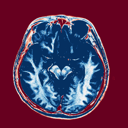
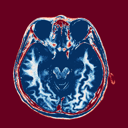
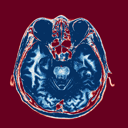
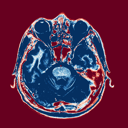
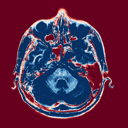

In [198]:
display_uri(n_qry.toPandas()['Preview4Q'])

In [80]:
f_qry = sqlContext.sql("""
SELECT Modality, FIRST(`Study ID`)  as Sid, COUNT(*) FROM ImageTable GROUP BY Modality
""")
f_qry.explain()

== Physical Plan ==
SortAggregate(key=[Modality#64], functions=[first(Study ID#3, false),count(1)])
+- *Sort [Modality#64 ASC], false, 0
   +- Exchange hashpartitioning(Modality#64, 200)
      +- SortAggregate(key=[Modality#64], functions=[partial_first(Study ID#3, false),partial_count(1)])
         +- *Sort [Modality#64 ASC], false, 0
            +- Project [Study ID#3, Modality#64]
               +- Scan ExistingRDD[[SliceMeasurementDuration]#0,Accession Number#1,Number of Phase Encoding Steps#2L,Study ID#3,Patient ID#4,Samples per Pixel#5L,Manufacturer's Model Name#6,[SlicePosition_PCS]#7,Protocol Name#8,[CoilString]#9,Performing Physician's Name#10,Transmit Coil Name#11,Green Palette Color Lookup Table Descriptor#12,[CSA Series Header Type]#13,Number of Averages#14,Patient Position#15,Patient's Name#16,Rows#17L,[CSA Series Header Version]#18,Performed Procedure Step Start Time#19,Blue Palette Color Lookup Table Descriptor#20,[CSA Image Header Version]#21,Red Palette Color Lookup Ta

In [81]:
f_qry.toPandas()

,Modality,Sid,count(1)
0,MR,685351,356


In [201]:
['bo']

KeyError: 'bo'

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 59550)
----------------------------------------


Traceback (most recent call last):
  File "/Users/mader/anaconda/lib/python3.5/socketserver.py", line 313, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/mader/anaconda/lib/python3.5/socketserver.py", line 341, in process_request
    self.finish_request(request, client_address)
  File "/Users/mader/anaconda/lib/python3.5/socketserver.py", line 354, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/mader/anaconda/lib/python3.5/socketserver.py", line 681, in __init__
    self.handle()
  File "/Volumes/ExDisk/spark-2.0.0-bin-hadoop2.7/python/pyspark/accumulators.py", line 235, in handle
    num_updates = read_int(self.rfile)
  File "/Volumes/ExDisk/spark-2.0.0-bin-hadoop2.7/python/pyspark/serializers.py", line 545, in read_int
    raise EOFError
EOFError


In [ ]:

kimg_df = kmeta_df.withColumn('Image', pull_tile_udf(kmeta_df['x']))

In [308]:
good_dict, bad_dict, vkeys = dicom_to_dict(temp_dicom)
#bad_dict.values()
print(bad_dict.keys())

dict_keys(['Study Instance UID', 'Scheduled Protocol Code Sequence', "Patient's Insurance Plan Code Sequence", '[CSA Series Header Info]', 'Pixel Data', 'Requested Procedure Code Sequence', '[CSA Image Header Info]', 'SOP Instance UID', 'SOP Class UID', 'Pixel Spacing', 'Referenced SOP Instance UID', "Performing Physician's Name", 'Scan Options', 'Blue Palette Color Lookup Table Data', 'Request Attributes Sequence', 'Procedure Code Sequence', 'Frame of Reference UID', "Referring Physician's Name", 'Image Orientation (Patient)', 'Green Palette Color Lookup Table Data', "Patient's Name", 'Image Position (Patient)', 'Storage Media File-set UID', 'Series Instance UID', 'Red Palette Color Lookup Table Data', 'Referenced SOP Class UID'])


In [195]:
print('Simple Field', vkeys['Institution Name'])
print('Complex Field', vkeys['Frame of Reference UID'])

Simple Field type_info(inferrable=True, realtype=StringType, has_nulltype=False, length=18, is_complex=False)
Complex Field type_info(inferrable=True, realtype=StructType(List(StructField(info,NullType,true),StructField(is_retired,NullType,true),StructField(is_transfer_syntax,BooleanType,true),StructField(name,StringType,true),StructField(type,NullType,true))), has_nulltype=True, length=52, is_complex=True)


In [387]:
full_dicom_list = dicoms_to_dict([dicom_simple_read(in_path, stop_before_pixels=True) for in_path in c_files])

In [399]:


# not needed at the moment
type_mat = conv_dicom_list.apply(lambda x: (x[0],type(x[0])),0)

Missing Columns {'Scan Options': 85}


,[SliceMeasurementDuration],Accession Number,Number of Phase Encoding Steps,Study ID,Patient ID,Samples per Pixel,Manufacturer's Model Name,[SlicePosition_PCS],Protocol Name,[CoilString],...,Requested Procedure Description,Angio Flag,Slice Location,High Bit,Instance Creation Date,Manufacturer,Imaging Frequency,Sequence Name,Percent Phase Field of View,Private Creator
0,80337.5,ME140606MR3016,384,685351,10092825,1,TrioTim,"[-111.98122861, -119.99775317, 45.05843735]",t2_blade_tra,C:HEA;HEP;NE2,...,tou bu mr,N,51.058437,7,20140606,SIEMENS,123.258578,tseBR2d1_28,100.0,SIEMENS MR HEADER


Missing Columns []


In [270]:
test_df = pd.DataFrame({'a': [0, np.NAN, 1], 'b': [np.NAN, 9, np.NAN]})

In [ ]:
o_df = dicoms_to_dict([temp_dicom, temp_dicom])
o_df.dropna(axis = 1)

In [ ]:
sqlContext.createDataFrame(o_df.dropna(axis = 1))

In [ ]:
dicom_to_dict(temp_dicom)

In [204]:
dicom_rows = sc.parallelize(c_files, 100).map(lambda in_path: 
                                 Row(**dicom_to_dict(dicom_simple_read(in_path, stop_before_pixels=True))[0]))

In [205]:
dicom_df = sqlContext.createDataFrame(dicom_rows)

In [206]:
dicom_df.registerTempTable('DICOMTable')


In [273]:
sqlContext.sql("""SELECT * FROM DICOMTable LIMIT 1""").toPandas()

In [340]:
full_dicom_list[icol].map(lambda x: np.array(x).tolist())

0               [ORIGINAL, PRIMARY, M, NORM, DIS2D]
1               [ORIGINAL, PRIMARY, M, NORM, DIS2D]
2               [ORIGINAL, PRIMARY, M, NORM, DIS2D]
3               [ORIGINAL, PRIMARY, M, NORM, DIS2D]
4               [ORIGINAL, PRIMARY, M, NORM, DIS2D]
5               [ORIGINAL, PRIMARY, M, NORM, DIS2D]
6               [ORIGINAL, PRIMARY, M, NORM, DIS2D]
7               [ORIGINAL, PRIMARY, M, NORM, DIS2D]
8               [ORIGINAL, PRIMARY, M, NORM, DIS2D]
9               [ORIGINAL, PRIMARY, M, NORM, DIS2D]
10              [ORIGINAL, PRIMARY, M, NORM, DIS2D]
11              [ORIGINAL, PRIMARY, M, NORM, DIS2D]
12              [ORIGINAL, PRIMARY, M, NORM, DIS2D]
13              [ORIGINAL, PRIMARY, M, NORM, DIS2D]
14              [ORIGINAL, PRIMARY, M, NORM, DIS2D]
15              [ORIGINAL, PRIMARY, M, NORM, DIS2D]
16     [ORIGINAL, PRIMARY, M, NORM, DIS2D, FM, FIL]
17     [ORIGINAL, PRIMARY, M, NORM, DIS2D, FM, FIL]
18     [ORIGINAL, PRIMARY, M, NORM, DIS2D, FM, FIL]
19     [ORIG

In [341]:
print(full_dicom_list[icol])
full_dicom_list['serialized'] = full_dicom_list[icol].map(lambda x: np.array(x).tolist())
tdf = sqlContext.createDataFrame(full_dicom_list[['serialized']])
tdf.registerTempTable('DICOMSingleTable')
sqlContext.sql("""SELECT * FROM DICOMSingleTable LIMIT 1""").first()

0               [ORIGINAL, PRIMARY, M, NORM, DIS2D]
1               [ORIGINAL, PRIMARY, M, NORM, DIS2D]
2               [ORIGINAL, PRIMARY, M, NORM, DIS2D]
3               [ORIGINAL, PRIMARY, M, NORM, DIS2D]
4               [ORIGINAL, PRIMARY, M, NORM, DIS2D]
5               [ORIGINAL, PRIMARY, M, NORM, DIS2D]
6               [ORIGINAL, PRIMARY, M, NORM, DIS2D]
7               [ORIGINAL, PRIMARY, M, NORM, DIS2D]
8               [ORIGINAL, PRIMARY, M, NORM, DIS2D]
9               [ORIGINAL, PRIMARY, M, NORM, DIS2D]
10              [ORIGINAL, PRIMARY, M, NORM, DIS2D]
11              [ORIGINAL, PRIMARY, M, NORM, DIS2D]
12              [ORIGINAL, PRIMARY, M, NORM, DIS2D]
13              [ORIGINAL, PRIMARY, M, NORM, DIS2D]
14              [ORIGINAL, PRIMARY, M, NORM, DIS2D]
15              [ORIGINAL, PRIMARY, M, NORM, DIS2D]
16     [ORIGINAL, PRIMARY, M, NORM, DIS2D, FM, FIL]
17     [ORIGINAL, PRIMARY, M, NORM, DIS2D, FM, FIL]
18     [ORIGINAL, PRIMARY, M, NORM, DIS2D, FM, FIL]
19     [ORIG

Row(serialized=['ORIGINAL', 'PRIMARY', 'M', 'NORM', 'DIS2D'])

In [331]:
for icol in full_dicom_list.columns:
    tdf = sqlContext.createDataFrame(full_dicom_list[[icol]])
    tdf.registerTempTable('DICOMSingleTable')
    sqlContext.sql("""SELECT * FROM DICOMSingleTable LIMIT 1""").first()

Py4JJavaError: An error occurred while calling z:org.apache.spark.sql.execution.python.EvaluatePython.takeAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 1765.0 failed 1 times, most recent failure: Lost task 2.0 in stage 1765.0 (TID 4408, localhost): java.lang.ClassCastException: net.razorvine.pickle.objects.ClassDict cannot be cast to java.util.ArrayList
	at net.razorvine.pickle.Unpickler.load_appends(Unpickler.java:673)
	at net.razorvine.pickle.Unpickler.dispatch(Unpickler.java:208)
	at net.razorvine.pickle.Unpickler.load(Unpickler.java:99)
	at net.razorvine.pickle.Unpickler.loads(Unpickler.java:112)
	at org.apache.spark.api.python.SerDeUtil$$anonfun$pythonToJava$1$$anonfun$apply$1.apply(SerDeUtil.scala:152)
	at org.apache.spark.api.python.SerDeUtil$$anonfun$pythonToJava$1$$anonfun$apply$1.apply(SerDeUtil.scala:151)
	at scala.collection.Iterator$$anon$12.nextCur(Iterator.scala:434)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:79)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:47)
	at org.apache.spark.scheduler.Task.run(Task.scala:85)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:274)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1450)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1438)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1437)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1437)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:811)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:811)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:811)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1659)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1618)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1607)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:632)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1871)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1884)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1897)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:347)
	at org.apache.spark.sql.execution.python.EvaluatePython$$anonfun$takeAndServe$1.apply$mcI$sp(EvaluatePython.scala:41)
	at org.apache.spark.sql.execution.python.EvaluatePython$$anonfun$takeAndServe$1.apply(EvaluatePython.scala:39)
	at org.apache.spark.sql.execution.python.EvaluatePython$$anonfun$takeAndServe$1.apply(EvaluatePython.scala:39)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:57)
	at org.apache.spark.sql.Dataset.withNewExecutionId(Dataset.scala:2532)
	at org.apache.spark.sql.execution.python.EvaluatePython$.takeAndServe(EvaluatePython.scala:39)
	at org.apache.spark.sql.execution.python.EvaluatePython.takeAndServe(EvaluatePython.scala)
	at sun.reflect.GeneratedMethodAccessor132.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:497)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:237)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:128)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:211)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.lang.ClassCastException: net.razorvine.pickle.objects.ClassDict cannot be cast to java.util.ArrayList
	at net.razorvine.pickle.Unpickler.load_appends(Unpickler.java:673)
	at net.razorvine.pickle.Unpickler.dispatch(Unpickler.java:208)
	at net.razorvine.pickle.Unpickler.load(Unpickler.java:99)
	at net.razorvine.pickle.Unpickler.loads(Unpickler.java:112)
	at org.apache.spark.api.python.SerDeUtil$$anonfun$pythonToJava$1$$anonfun$apply$1.apply(SerDeUtil.scala:152)
	at org.apache.spark.api.python.SerDeUtil$$anonfun$pythonToJava$1$$anonfun$apply$1.apply(SerDeUtil.scala:151)
	at scala.collection.Iterator$$anon$12.nextCur(Iterator.scala:434)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:79)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:47)
	at org.apache.spark.scheduler.Task.run(Task.scala:85)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:274)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [245]:
# calculate the schema on the first row
tiny_schema = sqlContext.createDataFrame(full_dicom_list.head(2))._schema
tiny_conv = _create_converter(tiny_schema)

def try_map(op, in_list):
    """
    error-tolerant try-map
    """
    def try_op(*args, **kwargs):
        try:
            return op(*args, **kwargs)
        except:
            return None
    return list(filter(lambda x: x is not None, map(try_op, in_list)))
conv_data = try_map(tiny_conv,full_dicom_list) #list(full_dicom_list.T.to_dict().values()))
dicom_single_df = sqlContext.createDataFrame(conv_data, schema = tiny_schema)
dicom_single_df.registerTempTable('DICOMSingleTable')

Py4JJavaError: An error occurred while calling z:org.apache.spark.sql.execution.python.EvaluatePython.takeAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 1665.0 failed 1 times, most recent failure: Lost task 0.0 in stage 1665.0 (TID 4157, localhost): java.lang.ClassCastException: net.razorvine.pickle.objects.ClassDict cannot be cast to java.util.ArrayList
	at net.razorvine.pickle.Unpickler.load_appends(Unpickler.java:673)
	at net.razorvine.pickle.Unpickler.dispatch(Unpickler.java:208)
	at net.razorvine.pickle.Unpickler.load(Unpickler.java:99)
	at net.razorvine.pickle.Unpickler.loads(Unpickler.java:112)
	at org.apache.spark.api.python.SerDeUtil$$anonfun$pythonToJava$1$$anonfun$apply$1.apply(SerDeUtil.scala:152)
	at org.apache.spark.api.python.SerDeUtil$$anonfun$pythonToJava$1$$anonfun$apply$1.apply(SerDeUtil.scala:151)
	at scala.collection.Iterator$$anon$12.nextCur(Iterator.scala:434)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:79)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:47)
	at org.apache.spark.scheduler.Task.run(Task.scala:85)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:274)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1450)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1438)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1437)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1437)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:811)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:811)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:811)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1659)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1618)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1607)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:632)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1871)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1884)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1897)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:347)
	at org.apache.spark.sql.execution.python.EvaluatePython$$anonfun$takeAndServe$1.apply$mcI$sp(EvaluatePython.scala:41)
	at org.apache.spark.sql.execution.python.EvaluatePython$$anonfun$takeAndServe$1.apply(EvaluatePython.scala:39)
	at org.apache.spark.sql.execution.python.EvaluatePython$$anonfun$takeAndServe$1.apply(EvaluatePython.scala:39)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:57)
	at org.apache.spark.sql.Dataset.withNewExecutionId(Dataset.scala:2532)
	at org.apache.spark.sql.execution.python.EvaluatePython$.takeAndServe(EvaluatePython.scala:39)
	at org.apache.spark.sql.execution.python.EvaluatePython.takeAndServe(EvaluatePython.scala)
	at sun.reflect.GeneratedMethodAccessor132.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:497)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:237)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:128)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:211)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.lang.ClassCastException: net.razorvine.pickle.objects.ClassDict cannot be cast to java.util.ArrayList
	at net.razorvine.pickle.Unpickler.load_appends(Unpickler.java:673)
	at net.razorvine.pickle.Unpickler.dispatch(Unpickler.java:208)
	at net.razorvine.pickle.Unpickler.load(Unpickler.java:99)
	at net.razorvine.pickle.Unpickler.loads(Unpickler.java:112)
	at org.apache.spark.api.python.SerDeUtil$$anonfun$pythonToJava$1$$anonfun$apply$1.apply(SerDeUtil.scala:152)
	at org.apache.spark.api.python.SerDeUtil$$anonfun$pythonToJava$1$$anonfun$apply$1.apply(SerDeUtil.scala:151)
	at scala.collection.Iterator$$anon$12.nextCur(Iterator.scala:434)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:79)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:47)
	at org.apache.spark.scheduler.Task.run(Task.scala:85)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:274)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [252]:
full_dicom_list.loc[1]

[SliceMeasurementDuration]                                                                 80335
Accession Number                                                                  ME140606MR3016
Number of Phase Encoding Steps                                                               384
Study ID                                                                                  685351
Patient ID                                                                              10092825
Samples per Pixel                                                                              1
Manufacturer's Model Name                                                                TrioTim
[SlicePosition_PCS]                                  [-111.98122861, -119.99775317, 39.05843735]
Protocol Name                                                                       t2_blade_tra
[CoilString]                                                                       C:HEA;HEP;NE2
Performing Physician's Name   

In [226]:
list(conv_data)[0]

(80335.0,
 'ME140606MR3016',
 384,
 '685351',
 '10092825',
 1,
 'TrioTim',
 [-111.98122861, -119.99775317, 39.05843735],
 't2_blade_tra',
 'C:HEA;HEP;NE2',
 (['', '', ''],
  ['iso8859', 'iso8859', 'iso8859'],
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  ''),
 'Body',
 [256, 0, 8],
 'MR',
 1.0,
 'HFS',
 (['HE JIAN RONG', '', ''],
  ['iso8859', 'iso8859', 'iso8859'],
  'HE JIAN RONG',
  '',
  '',
  '',
  '',
  '',
  'HE JIAN RONG',
  '',
  'HE JIAN RONG'),
 64,
 '20140606',
 '111723.828000',
 [256, 0, 8],
 '20140606',
 [256, 0, 8],
 't2_blade_tra',
 2,
 0.94054930573562,
 64,
 362.0,
 '2D',
 'A1/SAT2',
 'MR nasopharynx +C',
 [0, 0, -1344],
 'WINDOW1',
 8,
 '20140606',
 'Street StreetNo,Guangzhou//FA4C24//,District,CN,ZIP',
 'IMAGE NUM 4',
 (['', '', ''],
  ['iso8859', 'iso8859', 'iso8859'],
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  ''),
 1,
 '384*384',
 '19820305',
 'syngo MR B17',
 '111951.109000',
 '',
 28,
 0,
 'SYSU Cancer Center',
 'peng^general',
 [{(): ('OW',
    b'\x

In [23]:
full_dicom_list

,[SliceMeasurementDuration],Accession Number,Number of Phase Encoding Steps,Study ID,Patient ID,Samples per Pixel,Manufacturer's Model Name,[SlicePosition_PCS],Protocol Name,[CoilString],...,Requested Procedure Description,Angio Flag,Slice Location,High Bit,Instance Creation Date,Manufacturer,Imaging Frequency,Sequence Name,Percent Phase Field of View,Private Creator
0,80337.5,ME140606MR3016,384,685351,10092825,1,TrioTim,"[-111.98122861, -119.99775317, 45.05843735]",t2_blade_tra,C:HEA;HEP;NE2,...,tou bu mr,N,51.058437,7,20140606,SIEMENS,123.258578,tseBR2d1_28,100.0,SIEMENS MR HEADER
1,80335.0,ME140606MR3016,384,685351,10092825,1,TrioTim,"[-111.98122861, -119.99775317, 39.05843735]",t2_blade_tra,C:HEA;HEP;NE2,...,tou bu mr,N,45.058437,7,20140606,SIEMENS,123.258578,tseBR2d1_28,100.0,SIEMENS MR HEADER
2,80335.0,ME140606MR3016,384,685351,10092825,1,TrioTim,"[-111.98122861, -119.99775317, 33.05843735]",t2_blade_tra,C:HEA;HEP;NE2,...,tou bu mr,N,39.058437,7,20140606,SIEMENS,123.258578,tseBR2d1_28,100.0,SIEMENS MR HEADER
3,80337.5,ME140606MR3016,384,685351,10092825,1,TrioTim,"[-111.98122861, -119.99775317, 27.05843735]",t2_blade_tra,C:HEA;HEP;NE2,...,tou bu mr,N,33.058437,7,20140606,SIEMENS,123.258578,tseBR2d1_28,100.0,SIEMENS MR HEADER
4,80337.5,ME140606MR3016,384,685351,10092825,1,TrioTim,"[-111.98122861, -119.99775317, 21.05843735]",t2_blade_tra,C:HEA;HEP;NE2,...,tou bu mr,N,27.058437,7,20140606,SIEMENS,123.258578,tseBR2d1_28,100.0,SIEMENS MR HEADER
5,80335.0,ME140606MR3016,384,685351,10092825,1,TrioTim,"[-111.98122861, -119.99775317, 15.05843639]",t2_blade_tra,C:HEA;HEP;NE2,...,tou bu mr,N,21.058436,7,20140606,SIEMENS,123.258578,tseBR2d1_28,100.0,SIEMENS MR HEADER
6,80335.0,ME140606MR3016,384,685351,10092825,1,TrioTim,"[-111.98122861, -119.99775317, 9.05843639]",t2_blade_tra,C:HEA;HEP;NE2,...,tou bu mr,N,15.058436,7,20140606,SIEMENS,123.258578,tseBR2d1_28,100.0,SIEMENS MR HEADER
7,80337.5,ME140606MR3016,384,685351,10092825,1,TrioTim,"[-111.98122861, -119.99775317, 3.05843663]",t2_blade_tra,C:HEA;HEP;NE2,...,tou bu mr,N,9.058437,7,20140606,SIEMENS,123.258578,tseBR2d1_28,100.0,SIEMENS MR HEADER
8,80337.5,ME140606MR3016,384,685351,10092825,1,TrioTim,"[-111.98122861, -119.99775317, -2.94156337]",t2_blade_tra,C:HEA;HEP;NE2,...,tou bu mr,N,3.058437,7,20140606,SIEMENS,123.258578,tseBR2d1_28,100.0,SIEMENS MR HEADER
9,80335.0,ME140606MR3016,384,685351,10092825,1,TrioTim,"[-111.98122861, -119.99775317, -8.94156361]",t2_blade_tra,C:HEA;HEP;NE2,...,tou bu mr,N,-2.941564,7,20140606,SIEMENS,123.258578,tseBR2d1_28,100.0,SIEMENS MR HEADER


In [45]:
from pyspark.sql.session import SparkSession
from pyspark.sql.types import _infer_schema, _merge_type
sess = SparkSession(sc)
sess._inferSchemaFromList(list(map(lambda x: x, full_dicom_list)))

TypeError: Can not infer schema for type: <class 'str'>

In [51]:
row_rdd = sc.parallelize(full_dicom_list.T.to_dict().values()).map(lambda x: Row(**x))
sqlContext.createDataFrame(row_rdd).registerTempTable("DicomTest")
sqlContext.sql("""SELECT * FROM DicomTest LIMIT 1""")

In [261]:
bad_rows = []
for i in range(2,full_dicom_list.shape[0]):
    full_dicom_list.head(i).tail(2).to_csv('test.csv')
    try:
        sqlContext.createDataFrame(pd.read_csv('test.csv')).registerTempTable('Test')
        sqlContext.sql("SELECT * FROM Test LIMIT 1").first()
    except:
        bad_rows += [i]
        
print(bad_rows)

[17, 63, 318]


In [262]:
bad_rc_pairs = []
for i in bad_rows:
    for col in full_dicom_list.columns:
        full_dicom_list[[col]].head(i).tail(2).to_csv('test2.csv')
        try:
            sqlContext.createDataFrame(pd.read_csv('test2.csv')).registerTempTable('Test')
            sqlContext.sql("SELECT * FROM Test LIMIT 1").first()
        except:
            bad_rc_pairs += [(i,col)]

In [263]:
bad_rc_pairs

[(17, 'Scan Options'), (63, 'Scan Options'), (318, 'Scan Options')]

In [266]:
full_dicom_list['Scan Options'].head(318).tail(2)

316    FS
317      
Name: Scan Options, dtype: object

In [91]:
with open('test2.csv', 'r') as f:
    test_txt = "".join(f.readlines())

In [92]:
test_txt

',Scan Options\n15,SAT2\n16,\n'

In [96]:
from io import StringIO
test_df = pd.read_csv(StringIO(',Scan Options\n15,SAT2\n16,\n'))
sqlContext.createDataFrame(test_df).registerTempTable('Test')
sqlContext.sql("SELECT * FROM Test LIMIT 1").toPandas()

TypeError: Can not merge type <class 'pyspark.sql.types.StringType'> and <class 'pyspark.sql.types.DoubleType'>

In [99]:
test_df.dropna(axis = 0)

,Unnamed: 0,Scan Options
0,15,SAT2


In [105]:
bad_entry = full_dicom_list[['Scan Options']].head(i).tail(2)

In [108]:
be_series = bad_entry['Scan Options']

In [110]:
be_series.astype(np.str0)

15    SAT2
16        
Name: Scan Options, dtype: object

In [111]:
be_series.map(lambda x: len(x))

15    4
16    0
Name: Scan Options, dtype: int64

In [112]:
?full_dicom_list.apply